По сути, для каждого человека я должен предсказать не один аутпут, а 400 с хером.

Однако же есть надежда, что типичные транзакции преобладают, и реальная размерность - десятки осей, а не сотни.

# Базовое решение для задачи C

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LinearRegression
from scipy import sparse

Читаем входные файлы с данными

In [3]:
transactions = pd.read_csv('transactions.csv')
customers_gender = pd.read_csv('customers_gender_train.csv')

In [4]:
test_list = set(transactions.customer_id.unique().tolist()).difference(customers_gender.customer_id.unique())
test_list_df = pd.DataFrame(list(test_list), columns = ['customer_id'])
test_list_df.head()

,customer_id
0,55705601
1,49283085
2,15040528
3,74727448
4,10469400


### Отсюда начинается базовое решение, оно мне не интересно

Берём расходные транзакции и формируем тестовую выборку

In [5]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [4]:
test_transactions = \
    pd.DataFrame(columns=set(transactions.customer_id.unique().tolist()).difference(customers_gender.customer_id.unique()),
                 index=train_transactions.mcc_code.unique())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)

train_grid = pd.DataFrame(columns=transactions.customer_id.unique(), index=train_transactions.mcc_code.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)

Добавляем признаки, относящиеся к дате.

In [5]:
for tr_table in [train_grid, test_transactions]:
    tr_table.columns = ['customer_id', 'mcc_code']
    tr_table['month_num'] = (train_transactions.day.max() + 15) // 30
    tr_table['year_num'] = (train_transactions.day.max() + 15) // 365

train_transactions['month_num'] = train_transactions.day // 30
train_transactions['year_num'] = train_transactions.day // 365

In [6]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['year_num', 'month_num', 'customer_id', 'mcc_code'])[['amount']].sum().reset_index(),
             how='left').fillna(0)

In [7]:
for month_shift in range(1, 5):
    train_shift = train_transactions.copy()
    train_shift['month_num'] = train_shift['month_num'] + month_shift
    train_shift = train_shift.rename(columns={"amount" : 'amount_{0}'.format(month_shift)})  
    train_shift = train_shift[['year_num', 'month_num', 'customer_id', 'mcc_code', 'amount_{0}'.format(month_shift)]]

    train_transactions = pd.merge(train_transactions, train_shift, 
                                  on=['year_num', 'month_num', 'customer_id', 'mcc_code'], how='left').fillna(0)
    test_transactions = pd.merge(test_transactions, train_shift, 
                                 on=['year_num', 'month_num', 'customer_id', 'mcc_code'], how='left').fillna(0)

In [8]:
for shift in range(1, 4):
    train_transactions['diff_{}_{}'.format(shift, shift + 1)] = \
        train_transactions['amount_{}'.format(shift)] - train_transactions['amount_{}'.format(shift + 1)]
    test_transactions['diff_{}_{}'.format(shift, shift + 1)] = \
        test_transactions['amount_{}'.format(shift)] - test_transactions['amount_{}'.format(shift + 1)]    

In [9]:
hasher = FeatureHasher(n_features=100000, input_type='string')
train_sparse = \
    hasher.fit_transform(train_transactions[['year_num', 'month_num', 'customer_id', 'mcc_code']].astype(str).as_matrix())

In [10]:
test_sparse = \
    hasher.transform(test_transactions[['year_num', 'month_num', 'customer_id', 'mcc_code']].astype(str).as_matrix())

In [11]:
train_sparse = sparse.hstack([train_sparse,
                              np.log(np.abs(train_transactions[['amount_1', 'amount_2', 'amount_3', 'amount_3',
                                                                'diff_1_2',  'diff_2_3',  'diff_3_4']]) + 1).as_matrix()
                             ])

test_sparse = sparse.hstack([test_sparse,
                             np.log(np.abs(test_transactions[['amount_1', 'amount_2', 'amount_3', 'amount_3',
                                                              'diff_1_2',  'diff_2_3',  'diff_3_4']]) + 1).as_matrix()
                            ])

Обучаемся на всех данных

In [12]:
shift = 1
clf = LinearRegression()
clf.fit(train_sparse, np.log(-train_transactions['amount'] + shift))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Предсказываем объём трат для тестовых данных и создаём файл с ответом

In [13]:
test_transactions['volume'] = np.e ** clf.predict(test_sparse) - shift
test_transactions[['customer_id', 'mcc_code', 'volume']].to_csv('baseline_c.csv', index=False)

In [6]:
test_transactions = None
train_transactions = None
train_sparse = None
test_sparse = None

# Немножко исследований, что же за данные перед нами

Факты:
* люди совершили всего 3% от всех возможных транзакций.
* 
* 

In [7]:
tmp = transactions[transactions.amount < 0].copy()
tmp['day'] = tmp.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)
maxday = max(tmp['day'])
tmp['amonth'] = (tmp['day']+30-1-maxday%30)//30
tmp.shape

(5541668, 8)

In [25]:
np.unique(tmp['amonth'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)

In [28]:
len(np.unique(tmp.day[tmp['amonth']==15]))

30

Последнего месяца у нас все 30 дней, зато первого всего 7. Наверное, первый будем выкидывать.

In [8]:
tmp = tmp.groupby(['customer_id', 'mcc_code', 'amonth'])[['amount']].sum().reset_index()

Складывание транзакций в 1 месяц схлопнуло всё в 5 раз

In [32]:
tmp.shape

(1344039, 4)

In [35]:
len(unique(tmp.mcc_code)), len(unique(tmp.customer_id)), len(unique(tmp.amonth))

(184, 14986, 16)

Люди совершили всего 3% от тех транзакций, что могли бы.

In [36]:
tmp.shape[0]/(len(unique(tmp.mcc_code))* len(unique(tmp.customer_id))* len(unique(tmp.amonth)))

0.030464098919861436

Человек был в среднем активен 9 из 10 месяцев. Достаточно много, чтобы нас не очень печалили нули.

In [57]:
person_month = tmp.groupby(['customer_id', 'amonth'])[['amount']].sum().reset_index()
person_month.shape[0]/(len(unique(person_month.customer_id))* len(unique(person_month.amonth)))

0.9116425330308288

создаём список ВСЕГО

In [12]:
tmp['lamount'] = log(-tmp['amount']+1)

In [90]:
train_grid = pd.DataFrame(columns=transactions.customer_id.unique(), index=tmp.mcc_code.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columnns = ['customer_id', 'mcc_code']

In [9]:
all_id = pd.DataFrame(transactions.customer_id.unique(), columns = ['customer_id'])
all_mc = pd.DataFrame(transactions.mcc_code.unique(), columns = ['mcc_code'])
all_id.index = all_id.customer_id
all_mc.index = all_mc.mcc_code
all_id.drop('customer_id', axis = 1, inplace = True)
all_mc.drop('mcc_code', axis = 1, inplace = True)

In [13]:
pvt15 = tmp[tmp.amonth == 15].pivot(index = 'customer_id', columns = 'mcc_code', values = 'lamount').fillna(0)

In [14]:
pvt15 = pvt15.join(all_id, how = 'outer').fillna(0)

Смотрим, как много радости могут описать главные компоненты. 

Оказывается - очень много. 20 компонент - 70% дисперсии. Половина компонент - почти всё.

0.679186676564


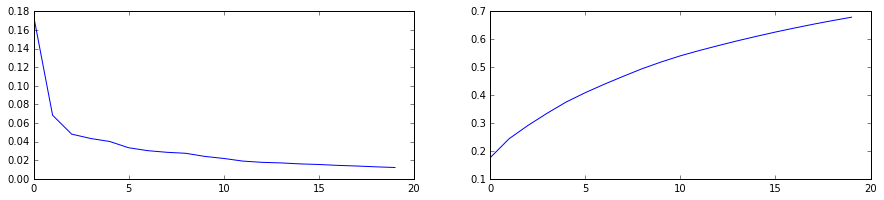

In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20).fit(pvt15)
print(sum(pca.explained_variance_ratio_))
_ = figure(figsize = (15, 3))
_ = subplot(1, 2, 1)
_ =plot(pca.explained_variance_ratio_)
_ = subplot(1, 2, 2)
_ =plot(cumsum(pca.explained_variance_ratio_))

1.0


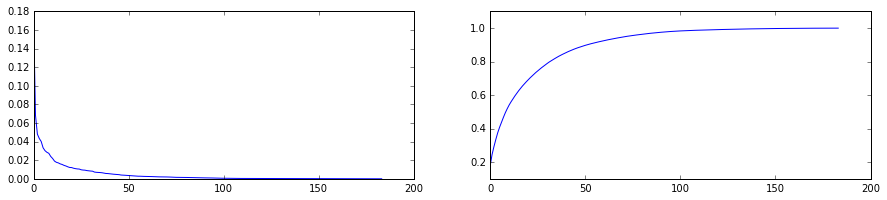

In [111]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 184).fit(pvt15)
print(sum(pca.explained_variance_ratio_))
_ = figure(figsize = (15, 3))
_ = subplot(1, 2, 1)
_ =plot(pca.explained_variance_ratio_)
_ = subplot(1, 2, 2)
_ =plot(cumsum(pca.explained_variance_ratio_))

Какую ошибку ГК дают на трейне? 0.77, то есть достаточно мало, чтобы нам хватило для полного, безграничного счастья.

In [112]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
pca = PCA(n_components = 20).fit(pvt15)
pvt15_pred = pca.inverse_transform(pca.transform(pvt15))
mean(mean((pvt15_pred-pvt15)**2))

0.7761258635742613

#### Приступаем к усреднению по трейну

In [15]:
tmp['amonth_customer_id'] = tmp['amonth'].astype('str')+'_'+tmp['customer_id'].astype('str')

In [16]:
pvts = []
for m in range(16):
    pvts.append(tmp[tmp.amonth == m].pivot(index = 'customer_id', columns = 'mcc_code', values = 'lamount')
                .join(all_id, how = 'outer').transpose().join(all_mc, how = 'outer').transpose().fillna(0))

In [17]:
for p in pvts:
    print(p.shape)

(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)
(15000, 184)


In [157]:
mean_all_train = pvts[1]*0
for m in range(1, 15):
    mean_all_train = mean_all_train + pvts[m]
mean_all_train = mean_all_train * 1.0/14

Если просто усреднить 14 периодов, получаем среднюю ошибку 1.32!

In [180]:
sqrt(((pvts[14]-pvts[15])**2).mean().mean())

1.6203364735053745

In [181]:
sqrt(((mean_all_train-pvts[15])**2).mean().mean())

1.3263625106734609

Если брать предыдущий период, средняя ошибка равна 1.62

In [23]:
target_tall = pvts[15].unstack().reset_index()
target_tall.columns = ['mcc_code', 'customer_id', 'lamount']
prevnames = []
for m in range(1, 15):
    prevname = 'lag_'+str(16-m)
    prevnames.append(prevname)
    target_tall[prevname] = pvts[m].unstack().reset_index()[0]

In [24]:
target_tall.head()

,mcc_code,customer_id,lamount,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2
0,742,6815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,742,22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,742,27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,742,28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,742,31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Объемы сделок линейно растут и выросли, суки, за год на треть!

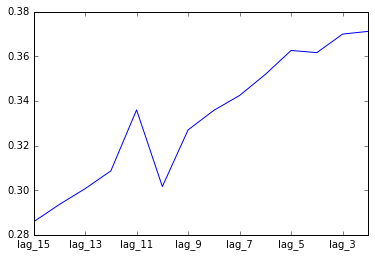

In [25]:
target_tall.mean()[prevnames].plot()

In [26]:
reg = LinearRegression()
reg.fit(target_tall[prevnames], target_tall['lamount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Коэффицииенты в хорошей регрессии, как и ожидается, возрастают примерно в геометрической прогрессии

0.970105448009 0.0377168839393


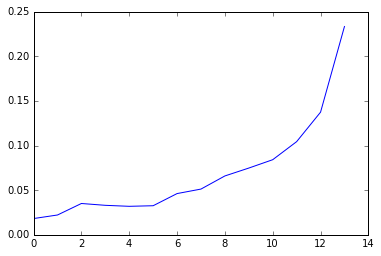

In [27]:
plot(reg.coef_)
print(sum(reg.coef_), reg.intercept_)

Оказалось, регрессия даёт ещё +4% к точности. 

Причём эта точность очень близка к точности на контесте.

In [28]:
sqrt(((reg.predict(target_tall[prevnames]) - target_tall['lamount'])**2).mean())

1.2885940021581177

Сразу же пробуем это эксплутарировать!

In [29]:
newnames = prevnames[1:]+['lamount']
newnames

['lag_14',
 'lag_13',
 'lag_12',
 'lag_11',
 'lag_10',
 'lag_9',
 'lag_8',
 'lag_7',
 'lag_6',
 'lag_5',
 'lag_4',
 'lag_3',
 'lag_2',
 'lamount']

In [30]:
target_tall['pr_15'] = reg.predict(target_tall[prevnames])

In [31]:
res_ext_15 = target_tall.pivot(index = 'customer_id', columns = 'mcc_code', values = 'pr_15')

In [52]:
target_tall['extrapolated'] = reg.predict(target_tall[newnames])

In [53]:
target_tall.pivot(index = 'customer_id', columns = 'mcc_code', values = 'extrapolated').to_csv('linreg_on_15_lags.csv')

In [190]:
target_tall['volume'] = np.e ** target_tall['extrapolated'] - shift

In [191]:
sum(target_tall['volume']<0), mean(target_tall['volume']<0)

(0, 0.0)

In [194]:
submission = target_tall[['customer_id', 'mcc_code', 'volume']]
submission.shape

(2760000, 3)

In [136]:
test_list = set(transactions.customer_id.unique().tolist()).difference(customers_gender.customer_id.unique())
test_list_df = pd.DataFrame(list(test_list), columns = ['customer_id'])
test_list_df.head()

,customer_id
0,55705601
1,49283085
2,15040528
3,74727448
4,10469400


In [207]:
submission = pd.merge(submission,test_list_df, on = 'customer_id')
submission.shape

(552000, 3)

In [208]:
submission.to_csv('c_01.csv', index=False)

### Делаем зависимость не только от своего, но и от чужого кода

Ниже - стандартный блок подготовки данных

In [5]:
tmp = transactions[transactions.amount < 0].copy()
tmp['day'] = tmp.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)
maxday = max(tmp['day'])
tmp['amonth'] = (tmp['day']+30-1-maxday%30)//30
tmp.shape

(5541668, 8)

In [6]:
tmp = tmp.groupby(['customer_id', 'mcc_code', 'amonth'])[['amount']].sum().reset_index()
tmp['lamount'] = log(-tmp['amount']+1)
tmp.shape

(1344039, 5)

In [7]:
all_id = pd.DataFrame(transactions.customer_id.unique(), columns = ['customer_id'])
all_mc = pd.DataFrame(transactions.mcc_code.unique(), columns = ['mcc_code'])
all_id.index = all_id.customer_id
all_mc.index = all_mc.mcc_code
all_id.drop('customer_id', axis = 1, inplace = True)
all_mc.drop('mcc_code', axis = 1, inplace = True)
all_mc.shape, all_id.shape

((184, 0), (15000, 0))

In [8]:
pvts = []
for m in range(16):
    pvts.append(tmp[tmp.amonth == m].pivot(index = 'customer_id', columns = 'mcc_code', values = 'lamount')
                .join(all_id, how = 'outer').transpose().join(all_mc, how = 'outer').transpose().fillna(0))

In [9]:
wide = pd.DataFrame(columns = ['customer_id']+pvts[0].columns.tolist() + ['amonth'])
for m in range(16):
    tmp = pvts[m].reset_index()
    tmp['amonth'] = m
    wide = pd.concat([wide, tmp])

In [10]:
wide.shape

(240000, 186)

In [22]:
"""
long = pd.DataFrame(columns = ['mcc_code', 'customer_id', 'lamount', 'amonth'])
for m in range(16):
    temp = pvts[m].unstack().reset_index()
    temp.columns =  ['mcc_code', 'customer_id', 'lamount']
    temp['amonth'] = m
    long = pd.concat([long, temp])
long.shape
"""
#Создаю таблицу с 44 миллионами наблюдений, ура!

"\nlong = pd.DataFrame(columns = ['mcc_code', 'customer_id', 'lamount', 'amonth'])\nfor m in range(16):\n    temp = pvts[m].unstack().reset_index()\n    temp.columns =  ['mcc_code', 'customer_id', 'lamount']\n    temp['amonth'] = m\n    long = pd.concat([long, temp])\nlong.shape\n"

План работы:
1. Делаю широкую табличку
2. херачу регрессию для каждого кода на все коды в прошлом месяце, а также несколько лагов
3. результаты запоминаю
4. профит!

In [32]:
wide.columns

Index(['customer_id',           742,          1711,          1731,
                1799,          2741,          3000,          3351,
                3501,          4111,
       ...
                8398,          8641,          8699,          8999,
                9211,          9222,          9311,          9399,
                9402,      'amonth'],
      dtype='object', name='mcc_code', length=186)

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

Запускаем регрессии на все коды с лагом 1. Если пойдёт хорошо, лагов потом добавим.

Оказалось, что ошибка на последнем периоде равна 1.3381304031486352. при $\alpha = 1.0$

1.3381124405681537 при альфе 100

1.3379676179439661 при альфе 10^4

1.3407195313548175 при альфе 10^5

Короче, масштаб регуляризации не очень важен.

In [16]:
maxlag = 0
skelet = wide[(wide.amonth > maxlag)&(wide.amonth < 15)].copy()
regressions = []
predictions = []
test_idx = (skelet.amonth == 14)
train_idx = (skelet.amonth < 14)
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
for code in all_mc.index:
    print(code, end = ', ')
    skelet['next_lamount'] = wide[(wide.amonth > (maxlag+1))&(wide.amonth <= 15)][code]
    for m in range(1, maxlag):
        skelet['lag_'+str(m+1)] = wide[(wide.amonth > (maxlag-m))&(wide.amonth < 15-m)][code]
    reg = Ridge(alpha = 10000.0, copy_X = False)
    reg.fit(skelet[train_idx][train_col], skelet[train_idx]['next_lamount'])
    pred = reg.predict(skelet[test_idx][train_col])
    regressions.append(reg)
    predictions.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [17]:
test_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    test_pred[code] = predictions[i]
sqrt(((test_pred-pvts[15])**2).mean().mean())

1.3407195313548175

Гляжу в книгу, вижу фигу: ошибка на тесте на 5% больше, чем я добивался простой экстраполяцией.

Во всём виноваты тупые нули?

In [101]:
mean(test_pred<0).mean()

0.22094384057971012

In [103]:
test_pred2 = test_pred.copy()
test_pred2[test_pred2<0] = 0

Нет, нули не особо влияют на обстановку.

In [106]:
sqrt(((test_pred2-pvts[15])**2).mean().mean())

1.3379869860861233

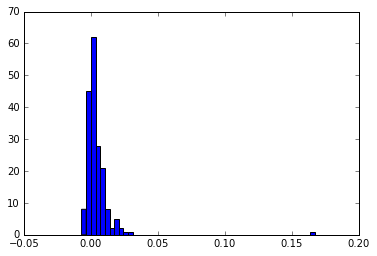

In [20]:
_ = hist(regressions[30].coef_, bins = 50)

In [143]:
import pickle
pickle.dump(regressions, open('C_regs_lag1_allcodes_a1e0.pkl', 'wb'))

Хочу смешать новый прогноз со старым

In [33]:
linreg_on_15_lags = pd.read_csv('linreg_on_15_lags.csv', index_col = 0)
linreg_on_15_lags.columns = linreg_on_15_lags.columns.astype(int)
linreg_on_15_lags.shape

(15000, 184)

Это - бейзлайн.

In [119]:
sqrt(((res_ext_15-pvts[15])**2).mean().mean())

1.2885940021563107

По всему выходит, что мою фигнюшку стоит брать с весом 0.3, а нормальную экстпраполяцию - с весом 0.7.

Пробуем!

In [125]:
for frac in [0, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]:
    between = res_ext_15*(1-frac) +test_pred * frac 
    print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0 1.28859400216
0.01 1.28774491717
0.03 1.28612726726
0.1 1.28131602459
0.2 1.27675953778
0.3 1.27495372063
0.4 1.27591025238
0.5 1.2796229384
0.7 1.29520437735
1.0 1.33813040315


А предсказывает эта штука быстро!

In [127]:
maxlag = 0
valid_skelet = wide[wide.amonth==15].copy()
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
final_preds = []
for i, code in enumerate(all_mc.index):
    print(code, end = ', ')
    reg = regressions[i]
    for m in range(1, maxlag):
        valid_skelet['lag_'+str(m+1)] = wide[wide.amonth==15-m][code]
    pred = reg.predict(valid_skelet[train_col])
    final_preds.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [128]:
valid_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    valid_pred[code] = final_preds[i]

In [134]:
submission = valid_pred * 0.3 + linreg_on_15_lags * 0.7
submission = submission.unstack().reset_index()
submission['volume'] = np.e ** submission[0] - 1
submission.head()

,mcc_code,customer_id,0,volume
0,742,6815,0.027202,0.027575
1,742,22899,0.030263,0.030726
2,742,27914,0.026472,0.026825
3,742,28753,0.028613,0.029026
4,742,31385,0.026457,0.026810


In [140]:
submission = pd.merge(submission[['customer_id', 'mcc_code', 'volume']],test_list_df, on = 'customer_id')
submission.shape

(552000, 3)

In [141]:
submission.to_csv('c_02.csv', index=False)

Загрузил решение, получил ожидаемый аплифт (1 п.п), но ещё 2 п.п. нужно добить, чтобы достать лидера.

Теперь вариант - поиграться с альфой, посмотреть, как будет меняться решение.

1e0 -> 1.33813, 1e2 -> 1.33811, 1e5 -> 1.35


In [152]:
regressions = []
predictions = []

for code in all_mc.index:
    print(code, end = ', ')
    skelet['next_lamount'] = wide[(wide.amonth > (maxlag+1))&(wide.amonth <= 15)][code]
    for m in range(1, maxlag):
        skelet['lag_'+str(m+1)] = wide[(wide.amonth > (maxlag-m))&(wide.amonth < 15-m)][code]
    reg = Ridge(alpha = 100.0, copy_X = False)
    reg.fit(skelet[train_idx][train_col], skelet[train_idx]['next_lamount'])
    pred = reg.predict(skelet[test_idx][train_col])
    regressions.append(reg)
    predictions.append(pred)
test_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    test_pred[code] = predictions[i]
print('\n', sqrt(((test_pred-pvts[15])**2).mean().mean()))

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [ ]:
alphas = [1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]
regressions = [[] for a in alphas]
predictions = [[] for a in alphas]
for code in all_mc.index:
    print(code, end = ', ')
    skelet['next_lamount'] = wide[(wide.amonth > (maxlag+1))&(wide.amonth <= 15)][code]
    for m in range(1, maxlag):
        skelet['lag_'+str(m+1)] = wide[(wide.amonth > (maxlag-m))&(wide.amonth < 15-m)][code]
    for i, alpha in enumerate(alphas):
        reg = Ridge(alpha = alpha, copy_X = False)
        reg.fit(skelet[train_idx][train_col], skelet[train_idx]['next_lamount'])
        pred = reg.predict(skelet[test_idx][train_col])
        regressions[i].append(reg)
        predictions[i].append(pred)
print('\n')
test_pred = pvts[15].copy()
for j, alpha in enumerate(alphas):
    for i, code in enumerate(all_mc.index):
        test_pred[code] = predictions[j][i]
    print(alpha, sqrt(((test_pred-pvts[15])**2).mean().mean()))

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 1000000.0 1.35995088502
100000000.0 1.53187731946
10000000000.0 1.56117700233


In [ ]:
test_pred = pvts[15].copy()
for j, alpha in enumerate(alphas):
    for i, code in enumerate(all_mc.index):
        test_pred[code] = predictions[j][i]
    print(alpha, sqrt(((test_pred-pvts[15])**2).mean().mean()))

#### Добавляю лагов и радуюсь

А ведь теперь для каждого кода можно было бы обучить какие-нибудь деревья!

Когда беру много лагов, то в итоге обучающий датасет получается коротеньким, и оперативной памяти нормально под всё хватает.

На 9 лагах я побил собственный рекорд!

0 лагов - 1.338

3 лага - 1.293122407109291

6 лагов - 1.2753228269107186

8 лагов - 1.2720708316892082

9 лагов - 1.2716188022050079

10 лагов - 1.2717021284285752

12 лагов (максимум) - 1.2755825113425898

In [12]:
maxlag = 9
skelet = wide[(wide.amonth > maxlag)&(wide.amonth < 15)].copy()
regressions = []
predictions = []
test_idx = (skelet.amonth == 14)
train_idx = (skelet.amonth < 14)
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
for code in all_mc.index:
    print(code, end = ', ')
    skelet['next_lamount'] = wide[(wide.amonth > (maxlag+1))&(wide.amonth <= 15)][code]
    for m in range(1, maxlag):
        skelet['lag_'+str(m+1)] = wide[(wide.amonth > (maxlag-m))&(wide.amonth < 15-m)][code]
    reg = Ridge(alpha = 1000.0, copy_X = False)
    reg.fit(skelet[train_idx][train_col], skelet[train_idx]['next_lamount'])
    pred = reg.predict(skelet[test_idx][train_col])
    regressions.append(reg)
    predictions.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [15]:
test_pred = pvts[15].copy() # эта таблица, на который мы сравниваемся с фактом
for i, code in enumerate(all_mc.index):
    test_pred[code] = predictions[i]
sqrt(((test_pred-pvts[15])**2).mean().mean())

1.2716188022050079

In [16]:
test_pred_c03_p15 = test_pred.copy()

А теперь предсказываем =)

In [17]:
maxlag = 9
valid_skelet = wide[wide.amonth==15].copy()
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
final_preds = []
for i, code in enumerate(all_mc.index):
    print(code, end = ', ')
    reg = regressions[i]
    for m in range(1, maxlag):
        valid_skelet['lag_'+str(m+1)] = wide[wide.amonth==15-m][code]
    pred = reg.predict(valid_skelet[train_col])
    final_preds.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [18]:
valid_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    valid_pred[code] = final_preds[i]
submission = valid_pred.unstack().reset_index()
submission['volume'] = np.e ** submission[0] - 1
submission.head()

,mcc_code,customer_id,0,volume
0,742,6815,-0.003353,-0.003348
1,742,22899,0.024252,0.024549
2,742,27914,-0.001874,-0.001872
3,742,28753,0.000858,0.000858
4,742,31385,0.000171,0.000171


In [19]:
submission[submission<0] = 0

In [20]:
submission = pd.merge(submission[['customer_id', 'mcc_code', 'volume']],test_list_df, on = 'customer_id')
submission.shape

(552000, 3)

In [21]:
submission_c03 = submission.copy()

Описываю третье решение: чужие коды с лагом 1, свой код с лагом 9

In [41]:
submission.to_csv('c_03.csv', index=False)

Третье решение не зашло (не побило второе). 

Пробуем смешивать снова!

In [48]:
for frac in [0, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    between = res_ext_15*(1-frac) +test_pred * frac 
    print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0 1.28859400216
0.01 1.28809081638
0.03 1.28710414822
0.1 1.28385847421
0.2 1.27978590949
0.3 1.27638265398
0.4 1.27365407296
0.5 1.27160450954
0.6 1.27023725056
0.7 1.26955450047
0.8 1.26955736364
0.9 1.27024583541
1.0 1.27161880221


In [41]:
frac = 0.75
between = res_ext_15*(1-frac) +test_pred * frac 
print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0.75 1.26947020465


In [42]:
between_c04 = between.copy()

О да, детка! Моего нового решения теперь хочется на 75%!

In [37]:
submission = valid_pred * 0.75 + linreg_on_15_lags * 0.25
submission = submission.unstack().reset_index()
submission['volume'] = np.e ** submission[0] - 1
submission.head()

,mcc_code,customer_id,0,volume
0,742,6815,0.006914,0.006938
1,742,22899,0.027618,0.028003
2,742,27914,0.008024,0.008056
3,742,28753,0.010072,0.010123
4,742,31385,0.009558,0.009603


In [38]:
submission[submission<0] = 0
submission = pd.merge(submission[['customer_id', 'mcc_code', 'volume']],test_list_df, on = 'customer_id')
submission.shape

(552000, 3)

In [39]:
submission_c04 = submission.copy()

In [57]:
submission.to_csv('c_04.csv', index=False)

Эта шняжка дала аплифт, но совсем незначительный

#### Двигаю в сторону PCA

0.680949786723


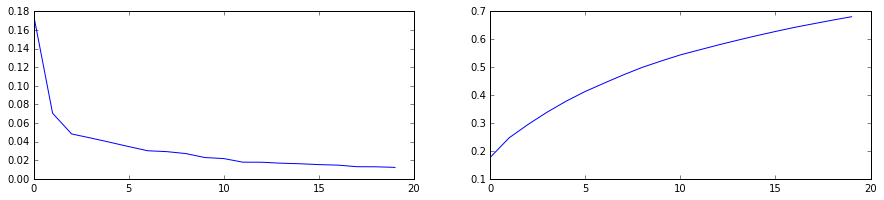

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20).fit(pvts[14])
print(sum(pca.explained_variance_ratio_))
_ = figure(figsize = (15, 3))
_ = subplot(1, 2, 1)
_ =plot(pca.explained_variance_ratio_)
_ = subplot(1, 2, 2)
_ =plot(cumsum(pca.explained_variance_ratio_))

In [61]:
frac = 0.75
best_pred = res_ext_15*(1-frac) +test_pred * frac 
print(sqrt(((best_pred-pvts[15])**2).mean().mean()))

1.26947020465


Само по себе проецирование ухудшает прогноз.

Лучше всего использовать 10-мерное пространство, и включать проекцию с весом 0.1. Но это вообще-то мало помогает.

In [65]:
for k in [1, 2, 3, 5, 10, 15, 20, 30, 50, 100]:
    pca = PCA(n_components = k).fit(pvts[14])
    proj = pca.inverse_transform(pca.transform(best_pred))
    frac = 0.1
    between = best_pred*(1-frac) +proj * frac
    print(k
          , sqrt(((proj-pvts[15])**2).mean().mean())
          , sqrt(((between-pvts[15])**2).mean().mean()))

1 1.45547531182 1.2704007702
2 1.42721582173 1.27007699629
3 1.41081035225 1.26979780113
5 1.37466388498 1.26928931633
10 1.33625317551 1.26900491731
15 1.3204736861 1.26907316466
20 1.31140491582 1.26919159392
30 1.29883474971 1.26927901158
50 1.28329935903 1.26950166469
100 1.27121647406 1.26946258983


In [66]:
pca = PCA(n_components = 10).fit(pvts[14])
proj = pca.inverse_transform(pca.transform(best_pred))
for frac in [0, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    between = best_pred*(1-frac) +proj * frac 
    print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0 1.26947020465
0.01 1.2693504941
0.03 1.2691598447
0.1 1.26900496116
0.2 1.27016612162
0.3 1.27294923532
0.4 1.27734370043
0.5 1.28333296399
0.6 1.29089482842
0.7 1.30000185144
0.8 1.31062182325
0.9 1.32271830241
1.0 1.33625119107


Использование более длинной истории данных не помогает.

In [67]:
pca = PCA(n_components = 10).fit(pvts[14])
proj = pca.inverse_transform(pca.transform(best_pred))
frac = 0.1
between = best_pred*(1-frac) +proj * frac 
print(frac, sqrt(((between-pvts[15])**2).mean().mean()))


0.1 1.26900499238


In [73]:
pca = PCA(n_components = 10).fit(wide[(wide.amonth > 6)&(wide.amonth < 15)][pvts[15].columns])
proj = pca.inverse_transform(pca.transform(best_pred))
frac = 0.1
between = best_pred*(1-frac) +proj * frac 
print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0.1 1.26902181996


Вывод: МГК мало подходит для трансформации выходного прогноза.

Однако его можно использовать для сокращения размерности пространства признаков, чтобы потом не страдать так сильно от недостатка памяти.

Прогнозируем

In [79]:
best_pred = valid_pred * 0.75 + linreg_on_15_lags * 0.25
pca = PCA(n_components = 10).fit(pvts[15])
proj = pca.inverse_transform(pca.transform(best_pred))
frac = 0.1
submission = best_pred*(1-frac) +proj * frac 

In [80]:
submission = submission.unstack().reset_index()
submission['volume'] = np.e ** submission[0] - 1
submission.head()

,mcc_code,customer_id,0,volume
0,742,6815,0.006793,0.006816
1,742,22899,0.024707,0.025014
2,742,27914,0.007271,0.007297
3,742,28753,0.010455,0.010510
4,742,31385,0.008683,0.008721


In [81]:
submission[submission<0] = 0
submission = pd.merge(submission[['customer_id', 'mcc_code', 'volume']],test_list_df, on = 'customer_id')
submission.shape

(552000, 3)

In [82]:
submission.to_csv('c_05.csv', index=False)

Как и ожидалось, в результате качество не выросло (упало на бесконечно малую величину).

# Восстанавливаюсь в последний вечер

In [44]:
"""
результаты работы c03 - чужие коды и своих 9 лагов
test_pred_c03_p15
submission_c03

res_ext_15 - прогноз на test_15 с вызова c_01
linreg_on_15_lags - прогноз на валидацию с c_01

between_c04
submission_c04 
"""
#

'\nрезультаты работы c03 - чужие коды и своих 9 лагов\ntest_pred_c03_p15\nsubmission_c03\n\nres_ext_15 - прогноз на test_15 с вызова c_01\nlinreg_on_15_lags - прогноз на валидацию с c_01\n\nbetween_c04\nsubmission_c04 \n'

#### clusters

0.681166514861


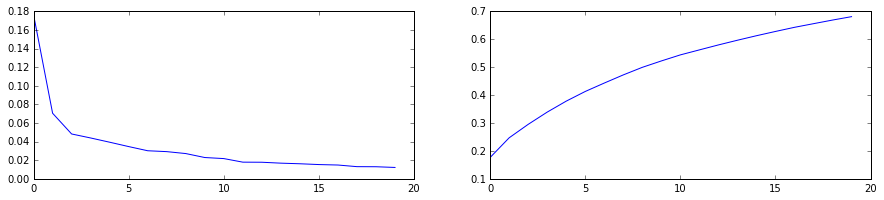

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20).fit(pvts[14])
print(sum(pca.explained_variance_ratio_))
_ = figure(figsize = (15, 3))
_ = subplot(1, 2, 1)
_ =plot(pca.explained_variance_ratio_)
_ = subplot(1, 2, 2)
_ =plot(cumsum(pca.explained_variance_ratio_))

In [81]:
pvts[0].shape

(15000, 184)

In [84]:
pcas = []
for t in range(16):
    pcas.append(pca.transform(pvts[t]))

In [89]:
wide_pca = np.concatenate(pcas,axis = 0)
wide_pca.shape, wide.shape

((240000, 20), (240000, 186))

array([False, False, False, ..., False, False, False], dtype=bool)

In [95]:
wide_pca[array((wide.amonth > (10))&(wide.amonth < 15)), 1].shape

(60000,)

In [96]:
maxlag = 9
maxlag_pca = 9
skelet = wide[(wide.amonth > maxlag)&(wide.amonth < 15)].copy()
regressions = []
predictions = []
test_idx = (skelet.amonth == 14)
train_idx = (skelet.amonth < 14)
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
for code in all_mc.index:
    print(code, end = ', ')
    skelet['next_lamount'] = wide[(wide.amonth > (maxlag+1))&(wide.amonth <= 15)][code]
    for m in range(1, maxlag):
        skelet['lag_'+str(m+1)] = wide[(wide.amonth > (maxlag-m))&(wide.amonth < 15-m)][code]
    for m in range(1, maxlag_pca):
        for comp in range(20):
            skelet['lag_'+str(m+1)+'_comp_'+str(comp)] = wide_pca[array((wide.amonth > (maxlag-m))&(wide.amonth < 15-m)), comp]
    reg = Ridge(alpha = 1000.0, copy_X = False)
    reg.fit(skelet[train_idx][train_col], skelet[train_idx]['next_lamount'])
    pred = reg.predict(skelet[test_idx][train_col])
    regressions.append(reg)
    predictions.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

Итак, я добавил лаги 20 главных компонент ко мне в предикторы. Получится ли повысить качество прогноза? Нифига

In [97]:
test_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    test_pred[code] = predictions[i]
sqrt(((test_pred-pvts[15])**2).mean().mean())

1.2716188022050079

выходит, главные компоненты не оч тащат в качестве регрессоров.

In [102]:
sqrt(((test_pred*0.1+between_c04*0.9-pvts[15])**2).mean().mean())

1.2694923528732414

In [119]:
tp2 = test_pred.copy()
tp2[tp2<0]=0
sqrt(((tp2-pvts[15])**2).mean().mean())

1.2711773874020695

In [120]:
sqrt(((tp2*0.1+between_c04*0.9-pvts[15])**2).mean().mean())

1.2694441570382111

### А если подключить деревья-классификаторы?

есть проблема: это сцука долго. Но что ж поделаешь...

In [122]:
from sklearn.tree import DecisionTreeRegressor

In [123]:
maxlag = 9
maxlag_pca = 9
skelet = wide[(wide.amonth > maxlag)&(wide.amonth < 15)].copy()
regressions = []
predictions = []
test_idx = (skelet.amonth == 14)
train_idx = (skelet.amonth < 14)
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
for code in all_mc.index:
    print(code, end = ', ')
    skelet['next_lamount'] = wide[(wide.amonth > (maxlag+1))&(wide.amonth <= 15)][code]
    for m in range(1, maxlag):
        skelet['lag_'+str(m+1)] = wide[(wide.amonth > (maxlag-m))&(wide.amonth < 15-m)][code]
    for m in range(1, maxlag_pca):
        for comp in range(20):
            skelet['lag_'+str(m+1)+'_comp_'+str(comp)] = wide_pca[array((wide.amonth > (maxlag-m))&(wide.amonth < 15-m)), comp]
    reg = DecisionTreeRegressor(min_samples_leaf = 100)
    reg.fit(skelet[train_idx][train_col], skelet[train_idx]['next_lamount'])
    pred = reg.predict(skelet[test_idx][train_col])
    regressions.append(reg)
    predictions.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [124]:
test_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    test_pred[code] = predictions[i]
sqrt(((test_pred-pvts[15])**2).mean().mean())

1.2991307134144399

Ага! если взять мои деревяшки, то на 10% они добавляют к имеющемуся скору нормально.

In [126]:
for w in [0.01, 0.03, 0.1, 0.3, 0.5]:
    print(w, sqrt(((test_pred*w+between_c04*(1-w)-pvts[15])**2).mean().mean()))

0.01 1.26933616128
0.03 1.26909434961
0.1 1.26852413137
0.3 1.26926397347
0.5 1.27350501498


In [127]:
maxlag = 9
valid_skelet = wide[wide.amonth==15].copy()
train_col = all_mc.index.tolist() + ['lag_'+str(m+1) for m in range(1, maxlag)]
final_preds = []
for i, code in enumerate(all_mc.index):
    print(code, end = ', ')
    reg = regressions[i]
    for m in range(1, maxlag):
        valid_skelet['lag_'+str(m+1)] = wide[wide.amonth==15-m][code]
    for m in range(1, maxlag_pca):
        for comp in range(20):
            skelet['lag_'+str(m+1)+'_comp_'+str(comp)] = wide_pca[array((wide.amonth > (maxlag-m))&(wide.amonth < 15-m)), comp]
    pred = reg.predict(valid_skelet[train_col])
    final_preds.append(pred)

4814, 6011, 4829, 5499, 5541, 5200, 5732, 6010, 5331, 5912, 5411, 5812, 6012, 5719, 5722, 5621, 5814, 5921, 5941, 5691, 5813, 5211, 4812, 5945, 5983, 5999, 5943, 5533, 6300, 7832, 8099, 5992, 3501, 6536, 7997, 5641, 4722, 5661, 5651, 7011, 5699, 5942, 7298, 7999, 5712, 5511, 5422, 5399, 4900, 7538, 5949, 5977, 5948, 5631, 5311, 5462, 4112, 8999, 8021, 5714, 5251, 4789, 7542, 5947, 3000, 8043, 5944, 5734, 5611, 5532, 4816, 7311, 5655, 6051, 7994, 5995, 5309, 5964, 8299, 8244, 4111, 4511, 9399, 5441, 7922, 5261, 7699, 7995, 7629, 5816, 5735, 5039, 5300, 5199, 4121, 5065, 7399, 7299, 8011, 7230, 9222, 5946, 5131, 5994, 5231, 8071, 5094, 5047, 5072, 7210, 5976, 5045, 7932, 4215, 5542, 5099, 5713, 4899, 7933, 5681, 5193, 1711, 6211, 8398, 5599, 5993, 8062, 5169, 4214, 5733, 5013, 7221, 5571, 7993, 5971, 5968, 7372, 5074, 5044, 5811, 5111, 8641, 7512, 7523, 9311, 8220, 7991, 7996, 4784, 5931, 7841, 3351, 4411, 1799, 5192, 5122, 742, 6513, 7278, 5969, 5970, 4131, 5965, 7395, 5950, 5085, 7273,

In [128]:
valid_pred = pvts[15].copy()
for i, code in enumerate(all_mc.index):
    valid_pred[code] = final_preds[i]
submission = valid_pred.unstack().reset_index()
submission['volume'] = np.e ** submission[0] - 1
submission.head()

,mcc_code,customer_id,0,volume
0,742,6815,0.0,0.0
1,742,22899,0.0,0.0
2,742,27914,0.0,0.0
3,742,28753,0.0,0.0
4,742,31385,0.0,0.0


In [129]:
submission = pd.merge(submission[['customer_id', 'mcc_code', 'volume']],test_list_df, on = 'customer_id')
submission.shape

(552000, 3)

In [136]:
submission_с06_raw = submission

In [140]:
submission_c06 = submission_с06_raw.copy()

In [141]:
submission_c06['volume'] = submission_с06_raw.volume*0.1+submission_c04.volume*0.9

In [142]:
submission_c06.to_csv('c_06.csv', index=False)

In [143]:
submission_c06.head()

,customer_id,mcc_code,volume
0,49101,742,0.006734
1,49101,1711,0.008447
2,49101,1731,0.009291
3,49101,1799,0.007909
4,49101,2741,0.008779


#### kmeans

Для разных моделей kmeans смотрю, сколько кластеров могут объяснить моих людишек нормально. 

Оказывается, около 20 кластеров для KMeans оптимально.

In [64]:
from sklearn.cluster import KMeans
for k in [1, 3, 6, 10, 20, 30, 50, 100]:
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(pvts[14])
    pred_cl = km.predict(pvts[14])
    pred_cc = km.cluster_centers_[pred_cl, :]
    print(k, sqrt(mean(mean((pred_cc-pvts[15])**2))))

1 1.55601374449
3 1.49060214959
6 1.47269205139
10 1.46818884583
20 1.46094254723
30 1.47224971025
50 1.47560332686
100 1.48415614277


От того, что усредняю 5 месяцев, клёвость кластеризации ещё возрастает!

In [65]:
km = KMeans(n_clusters = 20, random_state = 42)
pvt = (pvts[14]+pvts[13]+pvts[12]+pvts[11]+pvts[10]) / 5
km.fit(pvt)
pred_cl = km.predict(pvt)
pred_cc = km.cluster_centers_[pred_cl, :]
print(sqrt(mean(mean((pred_cc-pvts[15])**2))))

1.41521521912


Но менее клёво, если усредняю за 3 месяца

In [67]:
km = KMeans(n_clusters = 20, random_state = 42)
pvt = (pvts[14]+pvts[13]+pvts[12]) / 3
km.fit(pvt)
pred_cl = km.predict(pvt)
pred_cc = km.cluster_centers_[pred_cl, :]
print(sqrt(mean(mean((pred_cc-pvts[15])**2))))

1.41859484331


Но менее клёво, если усредняю за все 10

In [66]:
km = KMeans(n_clusters = 20, random_state = 42)
pvt = (pvts[14]+pvts[13]+pvts[12]+pvts[11]+pvts[10]+pvts[9]+pvts[8]+pvts[7]+pvts[6]+pvts[5]) / 10
km.fit(pvt)
pred_cl = km.predict(pvt)
pred_cc = km.cluster_centers_[pred_cl, :]
print(sqrt(mean(mean((pred_cc-pvts[15])**2))))

1.42470533185


Сколько же мне добавить k-means к имеющемуся прогнозу?

In [72]:
km = KMeans(n_clusters = 20, random_state = 42)
pvt = (pvts[14]+pvts[13]+pvts[12]+pvts[11]+pvts[10]) / 5
km.fit(pvt)
pred_cl = km.predict(pvt)
pred_cc = km.cluster_centers_[pred_cl, :]
print(sqrt(mean(mean((pred_cc-pvts[15])**2))))

1.41521521912


Три процента красная цена моим добавочкам (и пользы в них примерно 0)

In [74]:
for frac in [0, 0.01, 0.03, 0.06, 0.1, 0.2]:
    between = between_c04*(1-frac) +pred_cc * frac 
    print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0 1.26947020465
0.01 1.2693847158
0.03 1.2693123187
0.06 1.26945019758
0.1 1.27009391845
0.2 1.27399593086


#### гауссовские смеси

Рассматриваю гауссовские смеси - будут ли они лучше kmeans? Сейчас предсказываю всё криспи. И чё-т не оч (точность порядка 1.50)

In [71]:
from sklearn.mixture import GaussianMixture
for k in [1, 3, 6, 10, 20, 30, 50, 100]:
    km = GaussianMixture(n_components = k, random_state = 42)
    pvt = (pvts[14]+pvts[13]+pvts[12]+pvts[11]+pvts[10]) / 5
    km.fit(pvt)
    pred_cl = km.predict(pvt)
    pred_cc = km.means_[pred_cl, :]
    print(k, sqrt(mean(mean((pred_cc-pvts[15])**2))))

1 1.55690549053
3 1.52758145741
6 1.51831367285
10 1.5141348795
20 1.50105708022
30 1.49104525403


KeyboardInterrupt: 

Обучаем на разных видах коваривционной матрицы, но всё не то и всё не так (лучше всего tied)

In [111]:
from sklearn.mixture import GaussianMixture
km = GaussianMixture(n_components = 20, random_state = 42, covariance_type = 'tied')
pvt = (pvts[14]+pvts[13]+pvts[12]+pvts[11]+pvts[10]) / 5
km.fit(pvt)
pred_cl = km.predict(pvt)
pred_cc = km.means_[pred_cl, :]
print(sqrt(mean(mean((pred_cc-pvts[15])**2))))

1.45410808099


Насколько растёт точность за счёт мягкости кластеризации? К сожалению, минимально - около 1%

In [114]:
pred_c2 = dot(km.predict_proba(pvt), km.means_)
print(sqrt(mean(mean((pred_с2-pvts[15])**2))))

1.4439504272


Такой добавке тоже цена три процента.

In [115]:
for frac in [0, 0.01, 0.03, 0.06, 0.1, 0.2]:
    between = between_c04*(1-frac) +pred_c2 * frac 
    print(frac, sqrt(((between-pvts[15])**2).mean().mean()))

0 1.26947020465
0.01 1.26939145085
0.03 1.26935173045
0.06 1.2695866182
0.1 1.27044909479
0.2 1.27534134355
